In [1]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
import scipy.stats as stat

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
c1 = pd.read_csv("c1.txt", sep=' ', names=['num'+str(i) for i in range(1, 11)], index_col=False)
c2 = pd.read_csv("c2.txt", sep=' ', names=['num'+str(i) for i in range(1, 11)], index_col=False)

In [3]:
# CTR по каждой группе в с1 и с2.
c1['click'] = c1.any(axis=1).apply(lambda x: int(x))
c2['click'] = c2.any(axis=1).apply(lambda x: int(x))

# Одная группа - 1000 сессий.
c1['group'] = np.array(c1.index.values / 1000).astype(int)
c2['group'] = np.array(c2.index.values / 1000).astype(int)

split1_ctr = pd.DataFrame(c1.groupby('group')['click'].mean())
split1_ctr.columns = ['ctr']
split2_ctr = pd.DataFrame(c2.groupby('group')['click'].mean())
split2_ctr.columns = ['ctr']

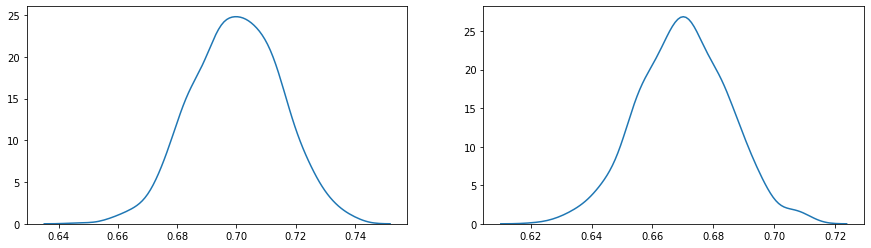

In [11]:
plt.figure(figsize=(15, 4))
plt.subplot(122)
sns.kdeplot(split2_ctr['ctr'].values)
plt.subplot(121)
sns.kdeplot(split1_ctr['ctr'].values)

Распределения похожи на нормальные, можно применять критерий стъюдента.

In [13]:
alpha = 0.05
iters_bootstrap = 1000
num_h0_false = 0

for i in range(iters_bootstrap):
    bootstrap1 = split1_ctr.sample(500, replace=True)
    bootstrap2 = split2_ctr.sample(500, replace=True)
    
    # Применяется критерий стъюдента для независимых выборок.
    _, p_value, _ = sm.stats.ttest_ind(bootstrap1['ctr'].values, bootstrap2['ctr'].values)
    
    # Если H0 - не верна.
    if p_value < alpha:
        num_h0_false += 1

print("Уровень значимости = {0}".format(float(num_h0_false) / iters_bootstrap))

Уровень значимости = 1.0


Нулевая гипотеза ни разу не была принята.

Проверим на метрику - доля кликов в первый результат.

In [14]:
c1['first_click'] = c1['num1']
c2['first_click'] = c2['num1']

split1_first = pd.DataFrame(c1.groupby('group')['first_click'].mean())
split1_first.columns = ['first']
split2_first = pd.DataFrame(c2.groupby('group')['first_click'].mean())
split2_first.columns = ['first']

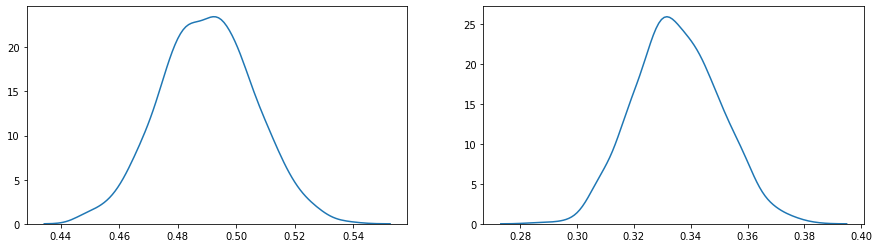

In [15]:
plt.figure(figsize=(15, 4))
plt.subplot(122)
sns.kdeplot(split2_first['first'].values)
plt.subplot(121)
sns.kdeplot(split1_first['first'].values)

In [16]:
alpha = 0.05
iters_bootstrap = 1000
num_h0_false = 0

for i in range(iters_bootstrap):
    bootstrap1 = split1_first.sample(500, replace=True)
    bootstrap2 = split2_first.sample(500, replace=True)
    
    # Применяется критерий стъюдента для независимых выборок.
    _, p_value, _ = sm.stats.ttest_ind(bootstrap1['first'].values, bootstrap2['first'].values)
    
    # Если H0 - не верна.
    if p_value < alpha:
        num_h0_false += 1
        
print("Уровень значимости = {0}".format(num_h0_false / iters_bootstrap))

Уровень значимости = 1.0


Вывод: т.к. по обоим метрикам различия каждый раз оказывались значимыми, и 2ая группа по обоим метрикам имеет сильно большие значения, то 2ой сплит лучше.